# Document Layout Clustering - embedding generation

Here we generate embeddings for a number of pages in each document using a general purpose VGG model.

In [80]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from dotenv import load_dotenv

load_dotenv()

CORPUS_PATH = os.getenv("CORPUS_PATH")

CORPUS_PATH

'/Users/kalyan/Documents/CPR/policy-search/data/corpus/content'

## 1. Get data

In [60]:
df = pd.read_csv("./vgg16_embeddings.tsv", sep="\t", index_col=0)
df = df.rename(columns={"filename": "s3_filepath"})
df["filename"] = df["s3_filepath"].apply(lambda i: f"{i[8:]}")
df['embedding'] = df['embedding'].apply(lambda i: np.array(i[1:-1].split(","), dtype="float32"))
df

,s3_filepath,page_num,embedding,filename
0,content/cclw-10000-99686d8409b541ec98b6938af58...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-10000-99686d8409b541ec98b6938af58af923.pdf
1,content/cclw-10000-99686d8409b541ec98b6938af58...,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-10000-99686d8409b541ec98b6938af58af923.pdf
2,content/cclw-10000-99686d8409b541ec98b6938af58...,13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-10000-99686d8409b541ec98b6938af58af923.pdf
3,content/cclw-10000-99686d8409b541ec98b6938af58...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-10000-99686d8409b541ec98b6938af58af923.pdf
4,content/cclw-10000-99686d8409b541ec98b6938af58...,26,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-10000-99686d8409b541ec98b6938af58af923.pdf
...,...,...,...,...
5242,content/cclw-4774-61e8d65f8225492899bb201560c7...,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-4774-61e8d65f8225492899bb201560c7fad3.pdf
5243,content/cclw-4774-61e8d65f8225492899bb201560c7...,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-4774-61e8d65f8225492899bb201560c7fad3.pdf
5244,content/cclw-4774-61e8d65f8225492899bb201560c7...,14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-4774-61e8d65f8225492899bb201560c7fad3.pdf
5245,content/cclw-4774-61e8d65f8225492899bb201560c7...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",cclw-4774-61e8d65f8225492899bb201560c7fad3.pdf


## 2. Reduce dimension of embeddings

In [37]:
embs = np.stack(df['embedding'].values)
embs.shape

(5247, 25088)

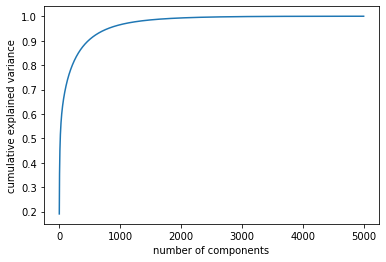

In [38]:
_pca = PCA(n_components=5000, random_state=42)
_pca.fit(embs)

def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    
pca_cumsum_plot(_pca)

In [39]:
pca = PCA(n_components=2000, random_state=42)
reduced_embs = pca.fit_transform(embs)
reduced_embs.shape

(5247, 2000)

## 3. Cluster embeddings

In [95]:
N_CLUSTERS = 15

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans_clusters = kmeans.fit_predict(reduced_embs)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type="full", random_state=42)
gmm_clusters = gmm.fit_predict(reduced_embs)

mupdf: cmsOpenProfileFromMem failed
mupdf: expected object number
mupdf: cmsOpenProfileFromMem failed
mupdf: xref subsection length missing


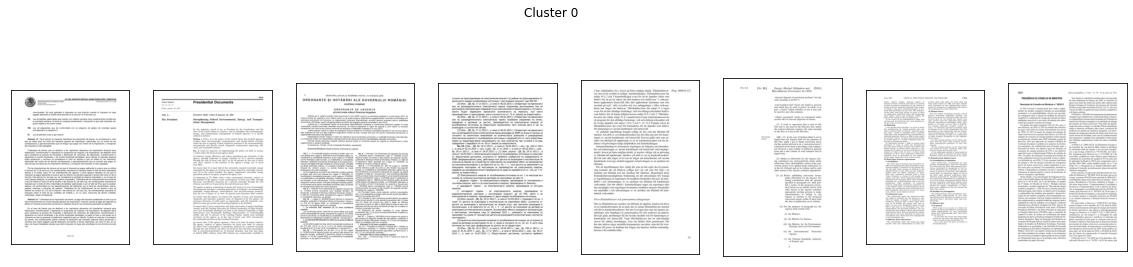

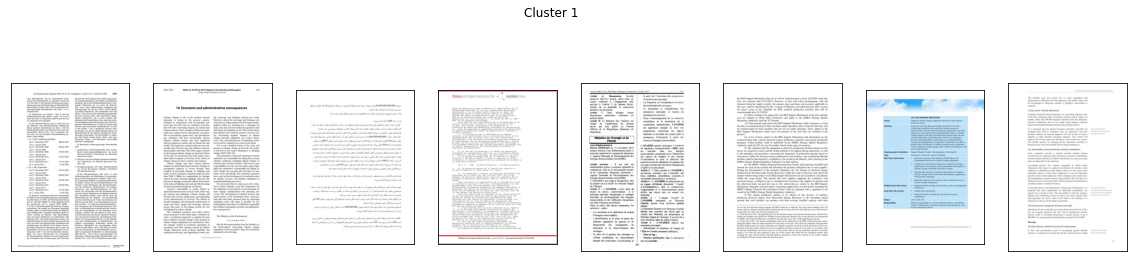

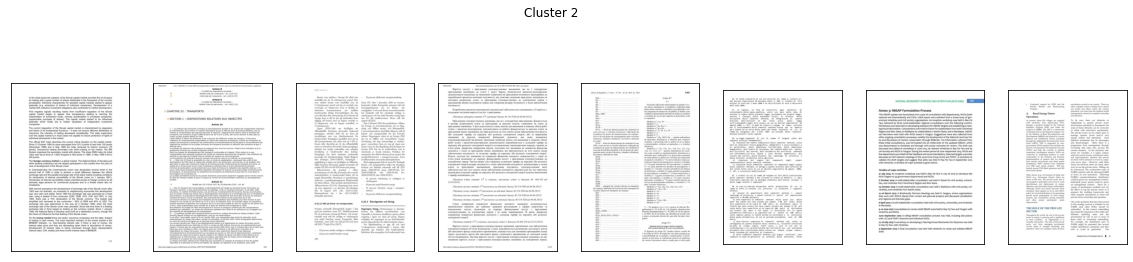

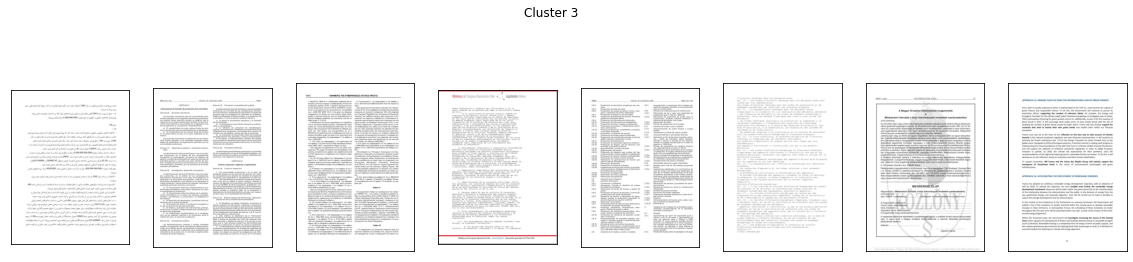

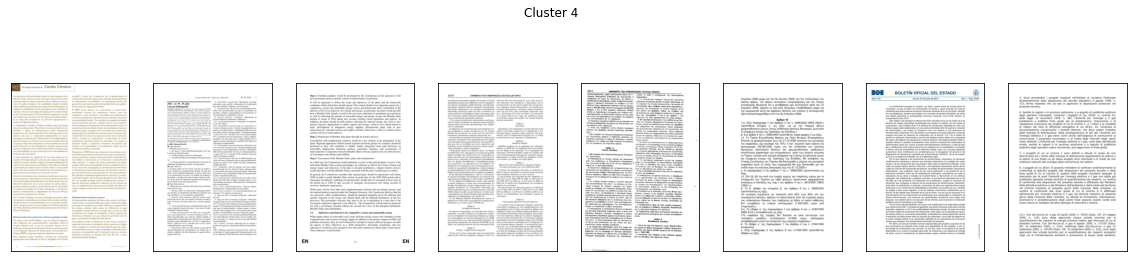

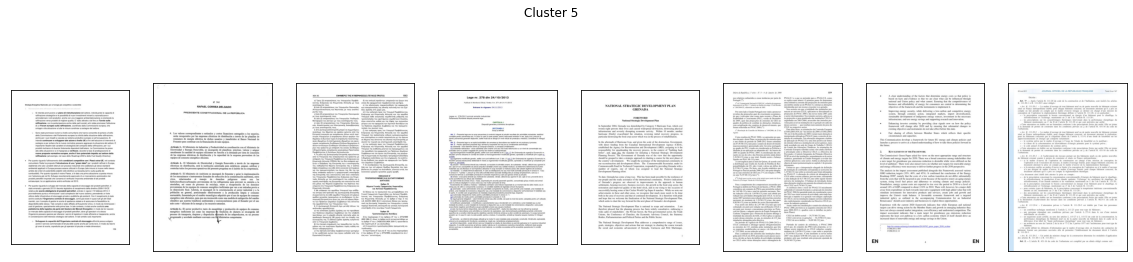

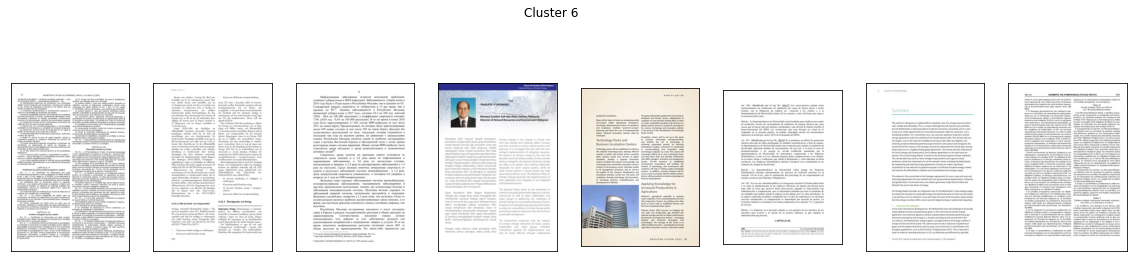

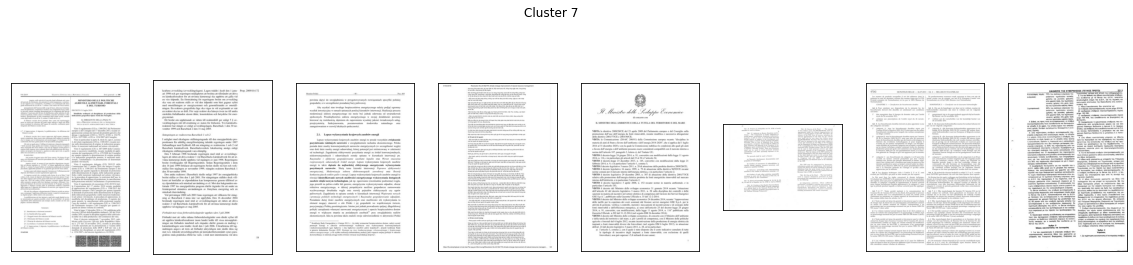

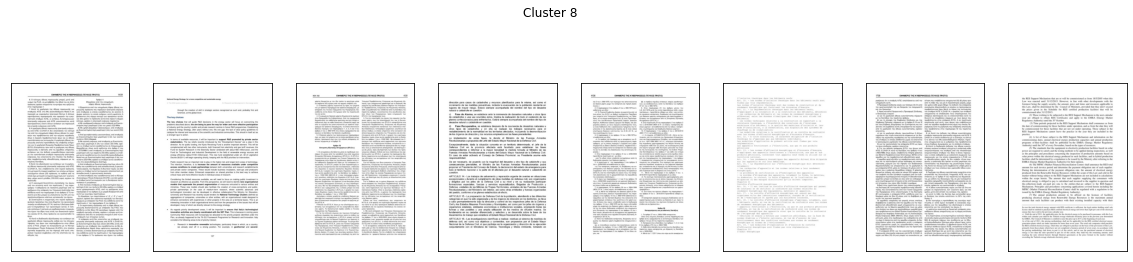

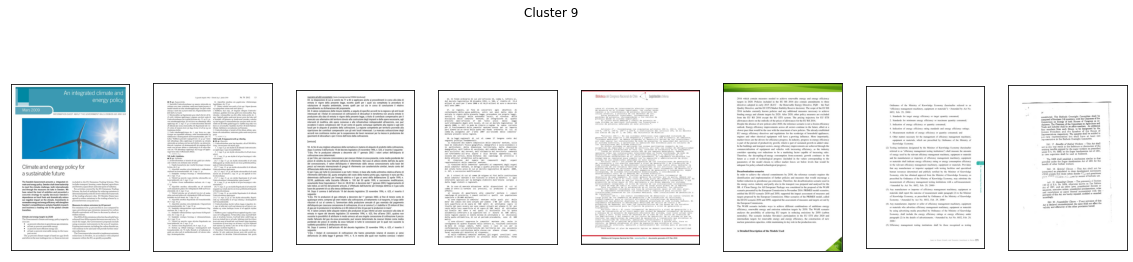

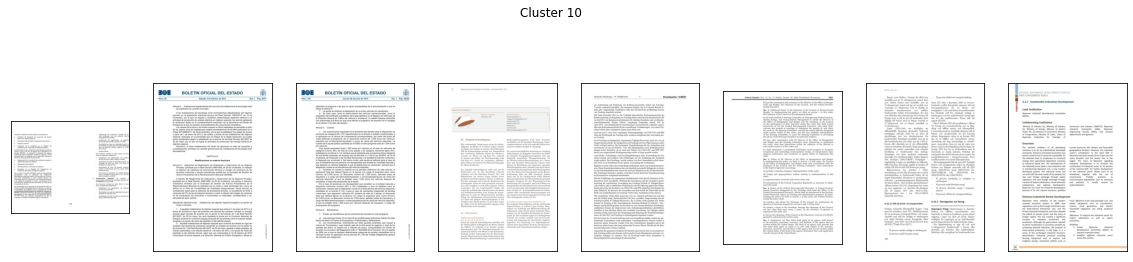

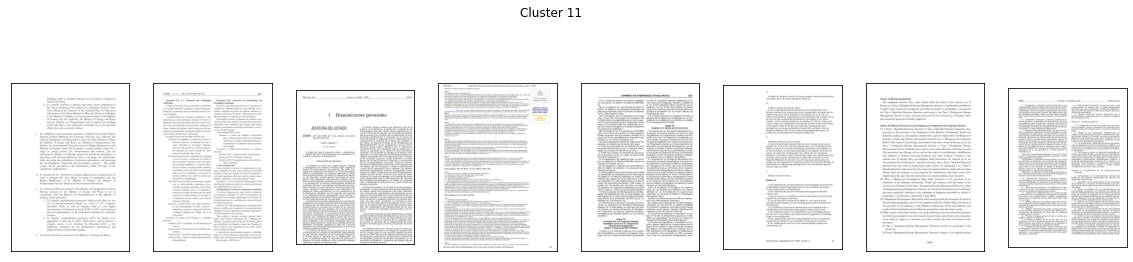

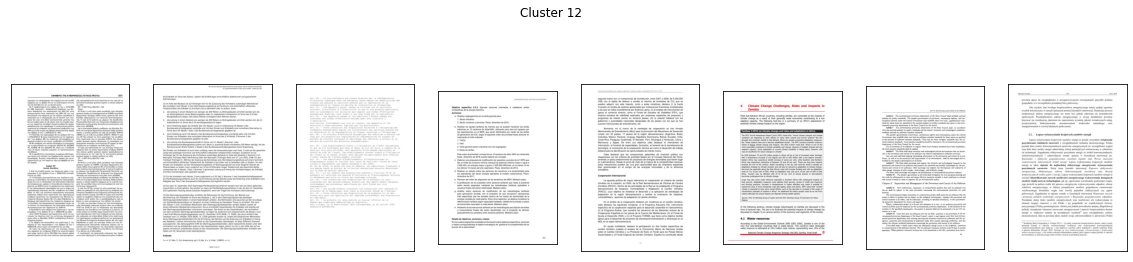

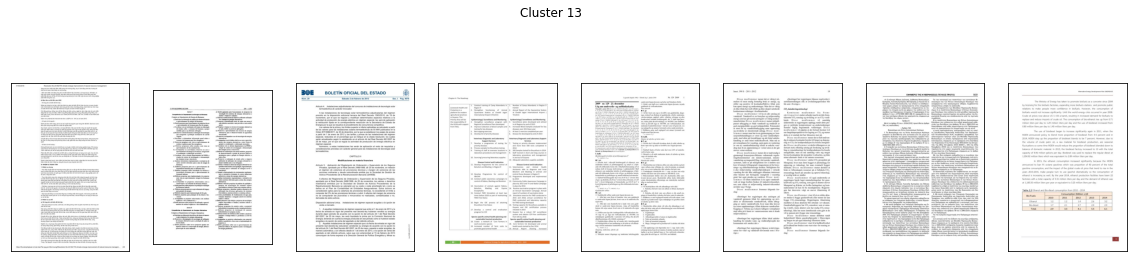

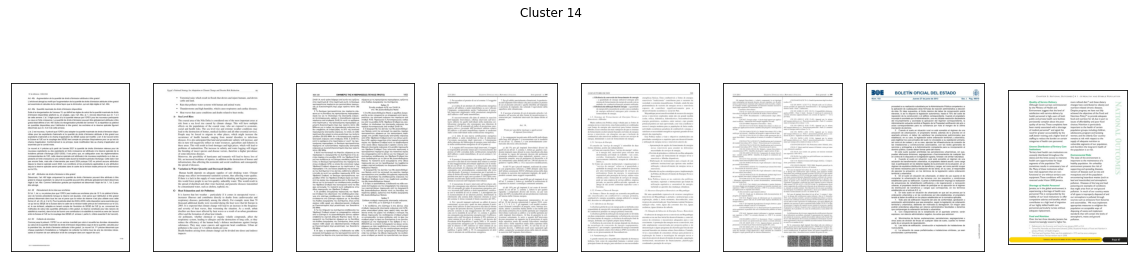

In [96]:
cluster_data = gmm_clusters

def page_to_image(page: 'Page') -> Image:
    pix = page.get_pixmap()
    input_bytes = pix.pil_tobytes(format="JPEG")

    return Image.open(io.BytesIO(input_bytes))


show_no_images_per_cluster = 8

for cluster_lbl in np.unique(cluster_data):
    
    sample_from_cluster = np.random.choice(
        np.where(clusters == 1)[0], 
        show_no_images_per_cluster, 
        replace=False
    )
    
    fig, axs = plt.subplots(nrows=1, ncols=show_no_images_per_cluster, figsize=(20,9))
    fig.suptitle(f"Cluster {cluster_lbl}", y=0.75)
    
    axs = list(axs)
    
    for _, row in df.iloc[sample_from_cluster].iterrows():
        doc = fitz.open(f"{CORPUS_PATH}/{row['filename']}")
        page = doc.load_page(row["page_num"])
        
        ax = axs.pop(0)
        ax.imshow(page_to_image(page))
        ax.set_xticks([])
        ax.set_yticks([])
    